Instrucciones:  descargar la siguiente base de datos de imágenes para clasificación de Kaggle

https://www.kaggle.com/ihelon/lego-minifigures-classification

In [ ]:
#Bibliotecas que vamos a necesitar
import os
import math
import time
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import albumentations as A
import torch
from torch.utils import data as torch_data
from torch import nn as torch_nn
import torchvision
from sklearn import metrics as sk_metrics

Vamos a utilizar la información dentro de nuestro Drive

In [ ]:
#Monta los archivos de nuestro Drive para que puedan usarse en Colab
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Establecemos el directorio de la base de datos
BASE_DIR = '/content/drive/My Drive/BasesDeDatos/lego/'

In [ ]:
#Función para establecer la semilla de números aleatorios utilizando Pytorch
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


#Esto es algo parecido a cuando configurabamos el random state en sklearn.
SEED = 42
set_seed(SEED)

In [ ]:
# Leemos la información asociada a la base de datos de imágenes
df = pd.read_csv(BASE_DIR+'index.csv', index_col=0)
df.head()


,path,class_id,train-valid
0,marvel/0001/001.jpg,1,train
1,marvel/0001/002.jpg,1,valid
2,marvel/0001/003.jpg,1,train
3,marvel/0001/004.jpg,1,train
4,marvel/0001/005.jpg,1,train


In [ ]:
# Obtener los objetos de entrenamiento
tmp_train = df[df['train-valid'] == 'train']
# Obtener las rutas de los objetos de entrenamiento
train_paths = tmp_train['path'].values
# Obtener las etiquetas asociadas a cada objeto (característica de salida)
train_targets = tmp_train['class_id'].values - 1
# Crear la ruta completa  (directorio base + archivo en concreto)
train_paths = list(map(lambda x: os.path.join(BASE_DIR, x), train_paths))
print(train_paths)

['/content/drive/My Drive/BasesDeDatos/lego/marvel/0001/001.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0001/003.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0001/004.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0001/005.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0001/007.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0002/001.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0002/003.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0002/004.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0002/005.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0002/007.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0003/001.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0003/003.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0003/004.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0003/005.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0003/007.jpg', '/content/drive/My Drive

In [ ]:
# Obtener los objetos de prueba
tmp_valid = df[df['train-valid'] == 'valid']
# Obtener las rutas de los objetos de prueba
valid_paths = tmp_valid['path'].values
# Obtener las etiquetas asociadas a cada objeto (característica de salida)
valid_targets = tmp_valid['class_id'].values - 1
# Crear la ruta completa  (directorio base + archivo en concreto)
valid_paths = list(map(lambda x: os.path.join(BASE_DIR, x), valid_paths))
print(valid_paths)

['/content/drive/My Drive/BasesDeDatos/lego/marvel/0001/002.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0001/006.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0001/008.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0001/009.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0001/010.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0002/002.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0002/006.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0002/008.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0002/009.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0002/010.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0003/002.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0003/006.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0003/008.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0003/009.jpg', '/content/drive/My Drive/BasesDeDatos/lego/marvel/0003/010.jpg', '/content/drive/My Drive

In [ ]:
#Identificar el número de clases entrenamiento
n_classes = len(np.unique(valid_targets))
print('Número de clases: ', n_classes)

Number of classes:  31


In [ ]:
#Identificar el número de clases prueba
n_classes = len(np.unique(train_targets))
print('Número de clases: ', n_classes)

Número de clases:  31


In [ ]:
#Procesamiento inicial de las imágenes
class DataRetriever(torch_data.Dataset):
    def __init__(
        self, 
        paths, 
        targets, 
        image_size=(224, 224),
        transforms=None
    ):
        self.paths = paths
        self.targets = targets
        self.image_size = image_size
        self.transforms = transforms
        self.preprocess = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            ),
        ])
          
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        img = cv2.resize(img, self.image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        img = self.preprocess(img)
        
        y = torch.tensor(self.targets[index], dtype=torch.long)
            
        return {'X': img, 'y': y}

In [ ]:
#Aplicamos algunas transformaciones a las imágenes para que el modelo generado sea más robusto
def get_train_transforms():
    return A.Compose(
        [
            A.Rotate(limit=30, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.Cutout(num_holes=8, max_h_size=20, max_w_size=20, p=0.25),
            A.Cutout(num_holes=8, max_h_size=20, max_w_size=20, p=0.25),
            A.HorizontalFlip(p=0.5),
            A.RandomContrast(limit=(-0.3, 0.3), p=0.5),
            A.RandomBrightness(limit=(-0.4, 0.4), p=0.5),
            A.Blur(p=0.25),
        ], 
        p=1.0
    )

In [ ]:
#Especificamos el tamaño estandar de las imágenes 
IMAGE_SIZE = (512, 512)


#Aplicamos las transformación que programos para hacer más robusto el modelo en ambos conjuntos tanto en el entrenamiento como en el de prueba
train_data_retriever = DataRetriever(
    train_paths, 
    train_targets, 
    image_size=IMAGE_SIZE,
    transforms=get_train_transforms()
)

valid_data_retriever = DataRetriever(
    valid_paths, 
    valid_targets, 
    image_size=IMAGE_SIZE,
)

In [ ]:
#Definimos el tamaño de la muestra que vamos a utilizar para entrenar y validar
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 1 

train_loader = torch_data.DataLoader(
    train_data_retriever,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
)

valid_loader = torch_data.DataLoader(
    valid_data_retriever, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

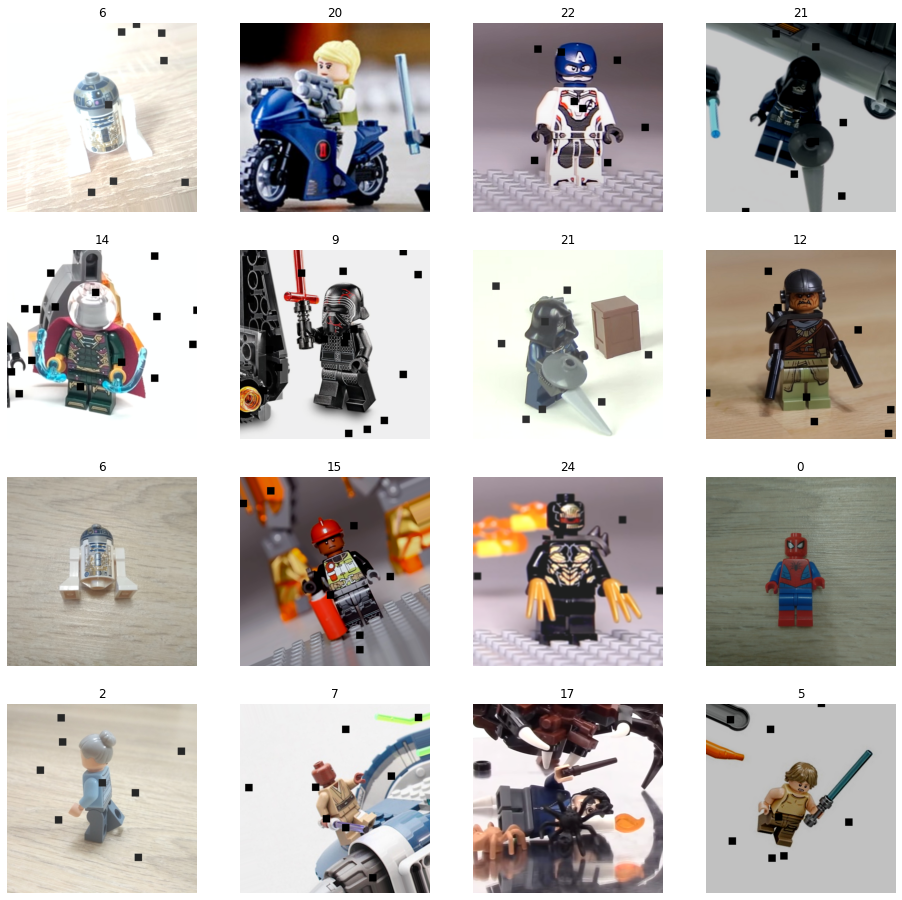

In [ ]:
#Desnormalizamos la imagen para poder visualizarla
def denormalize_image(image):
    return image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]

#Visualización de algunos lotes de imágenes dentro del entrenamiento
plt.figure(figsize=(16, 16))
for i_batch, batch in enumerate(train_loader):
    images, labels = batch['X'], batch['y']
    for i in range(len(images)):
        plt.subplot(4, 4, 4 * i_batch + i + 1)
        plt.imshow(denormalize_image(images[i].permute(1, 2, 0).numpy()))
        plt.title(labels[i].numpy())
        plt.axis('off')
    if i_batch >= 3:
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

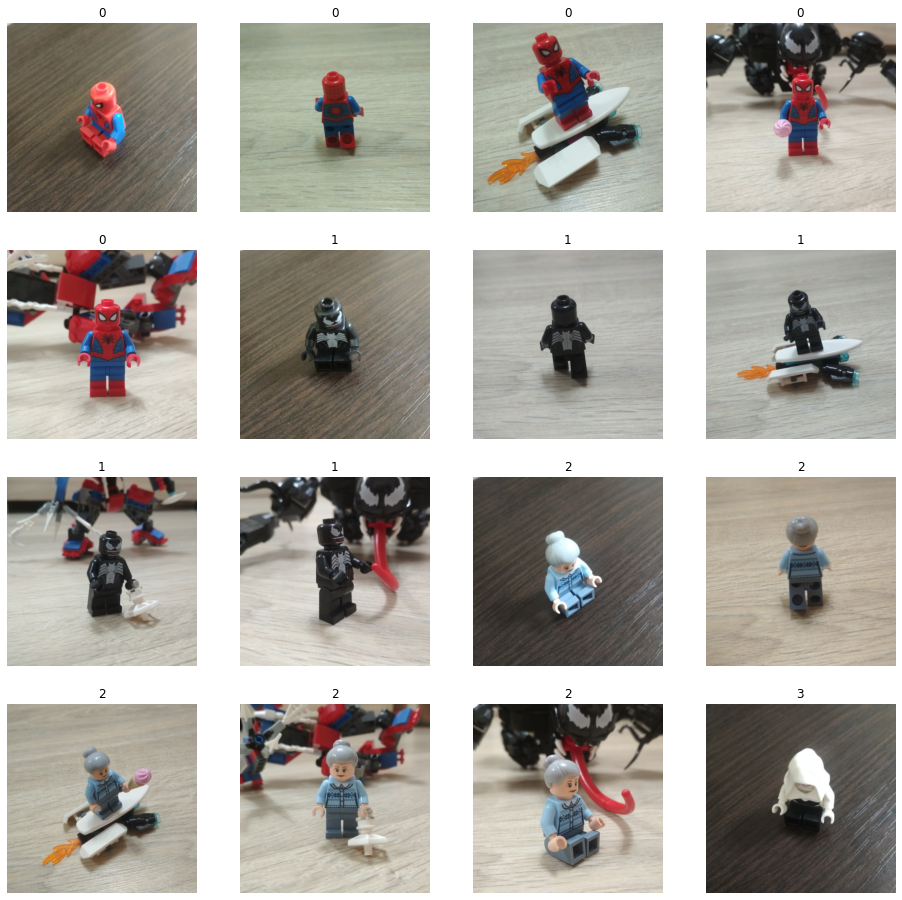

In [ ]:
#Visualización de algunos lotes de imágenes dentro del entrenamiento
plt.figure(figsize=(16, 16))
for i_batch, batch in enumerate(valid_loader):
    images, labels = batch['X'], batch['y']
    plt.subplot(4, 4, i_batch + 1)
    plt.imshow(denormalize_image(images[0].permute(1, 2, 0).numpy()))
    plt.title(labels[0].numpy())
    plt.axis('off')
    if i_batch >= 15:
        break

In [ ]:
#Configuramos la red neuronal profunda que vamos a utilizar
def get_net():
    net = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
    net.classifier = torch_nn.Linear(in_features=1280, out_features=n_classes, bias=True)
    return net

In [ ]:
#Definimos la función de optimización para entrenar el modelo
class LossMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0

    def update(self, val):
        self.n += 1
        # incremental update
        self.avg = val / self.n + (self.n - 1) / self.n * self.avg

# Definimos la función para evaluar el modelo en este caso precisión        
class AccMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().astype(int)
        y_pred = y_pred.cpu().numpy().argmax(axis=1).astype(int)
        last_n = self.n
        self.n += len(y_true)
        true_count = np.sum(y_true == y_pred)
        # incremental update
        self.avg = true_count / self.n + last_n / self.n * self.avg

In [ ]:
#Definimos la configuración completa para generar el modelo
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        loss_meter, 
        score_meter
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss_meter = loss_meter
        self.score_meter = score_meter
        
        self.best_valid_score = 0
        self.n_patience = 0
    
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_score, train_time = self.train_epoch(train_loader)
            valid_loss, valid_score, valid_time = self.valid_epoch(valid_loader)
            
            m = '[Epoch {}: Train] loss: {:.5f}, score: {:.5f}, time: {} s'
            self.info_message(
                m, n_epoch, train_loss, train_score, train_time
            )
            m = '[Epoch {}: Valid] loss: {:.5f}, score: {:.5f}, time: {} s'
            self.info_message(
                m, n_epoch, valid_loss, valid_score, valid_time
            )
            
            if self.best_valid_score < valid_score:
                m = 'The score improved from {:.5f} to {:.5f}. Save model to "{}"'
                self.info_message(
                    m, self.best_valid_score, valid_score, save_path
                )
                self.save_model(n_epoch, save_path)
                self.best_valid_score = valid_score
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                m = "\nValid score didn't improve last {} epochs."
                self.info_message(m, patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        train_loss = self.loss_meter()
        train_score = self.score_meter()
        
        for step, batch in enumerate(train_loader, 1):
            images = batch['X'].to(self.device)
            targets = batch['y'].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(images)

            loss = self.criterion(outputs, targets)
            loss.backward()

            train_loss.update(loss.detach().item())
            train_score.update(targets, outputs.detach())

            self.optimizer.step()
            
            _loss, _score = train_loss.avg, train_score.avg
            _time = int(time.time() - t)
            m = '[Train {}/{}] loss: {:.5f}, score: {:.5f}, time: {} s'
            self.info_message(
                m, step, len(train_loader), _loss, _score, _time, end='\r'
            )

        self.info_message('')
        
        return train_loss.avg, train_score.avg, int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        valid_loss = self.loss_meter()
        valid_score = self.score_meter()

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                images = batch['X'].to(self.device)
                targets = batch['y'].to(self.device)

                outputs = self.model(images)
                loss = self.criterion(outputs, targets)

                valid_loss.update(loss.detach().item())
                valid_score.update(targets, outputs)

            _loss, _score = valid_loss.avg, valid_score.avg
            _time = int(time.time() - t)
            m = '[Valid {}/{}] loss: {:.5f}, score: {:.5f}, time: {} s'
            self.info_message(
                m, step, len(valid_loader), _loss, _score, _time, end='\r'
            )

        self.info_message('')
        
        return valid_loss.avg, valid_score.avg, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path):
        torch.save(
            {
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'best_valid_score': self.best_valid_score,
                'n_epoch': n_epoch,
            },
            save_path,
        )
    
    @staticmethod
    def info_message(message, *args, end='\n'):
        print(message.format(*args), end=end)

In [ ]:
epochs = 50
patience = 3
model_save_path = 'model.torch'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = get_net()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch_nn.CrossEntropyLoss()

trainer = Trainer(
    model, 
    device, 
    optimizer, 
    criterion, 
    LossMeter, 
    AccMeter
)
trainer.fit(
    epochs, 
    train_loader, 
    valid_loader, 
    model_save_path, 
    patience
)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



EPOCH: 1
[Train 46/46] loss: 3.47459, score: 0.04945, time: 205 s
[Valid 170/170] loss: 3.06099, score: 0.24118, time: 87 s
[Epoch 1: Train] loss: 3.47459, score: 0.04945, time: 205 s
[Epoch 1: Valid] loss: 3.06099, score: 0.24118, time: 87 s
The score improved from 0.00000 to 0.24118. Save model to "model.torch"
EPOCH: 2
[Train 46/46] loss: 2.98171, score: 0.22527, time: 130 s
[Valid 170/170] loss: 2.61670, score: 0.40000, time: 26 s
[Epoch 2: Train] loss: 2.98171, score: 0.22527, time: 130 s
[Epoch 2: Valid] loss: 2.61670, score: 0.40000, time: 26 s
The score improved from 0.24118 to 0.40000. Save model to "model.torch"
EPOCH: 3
[Train 46/46] loss: 2.63343, score: 0.40659, time: 130 s
[Valid 170/170] loss: 2.20176, score: 0.57647, time: 27 s
[Epoch 3: Train] loss: 2.63343, score: 0.40659, time: 130 s
[Epoch 3: Valid] loss: 2.20176, score: 0.57647, time: 27 s
The score improved from 0.40000 to 0.57647. Save model to "model.torch"
EPOCH: 4
[Train 46/46] loss: 2.27914, score: 0.56593, 

In [ ]:
# Load the best model
checkpoint = torch.load(model_save_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_valid_score = checkpoint['best_valid_score']
n_epoch = checkpoint['n_epoch']

model.eval();

In [ ]:
# Guardamos las predicciones del modelo y las etiquetas reales
y_pred = []
y_valid = []
for batch in valid_loader:
    y_pred.extend(model(batch['X'].to(device)).argmax(axis=-1).cpu().numpy())
    y_valid.extend(batch['y'])

# Calculate needed metrics
print(f'Precisión obtenida utilizando las imágenes de prueba:\t{sk_metrics.accuracy_score(y_valid, y_pred)}')

Precisión obtenida utilizando las imágenes de prueba:	0.9705882352941176


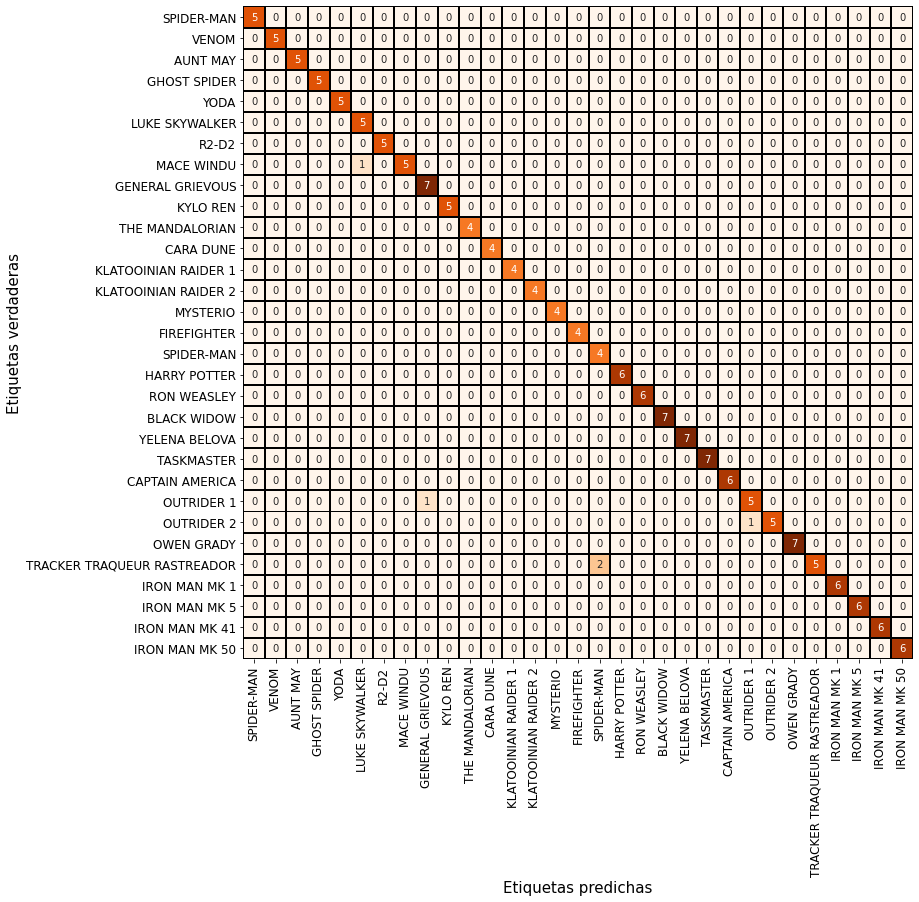

In [ ]:
# Cargamos la infromación relaciona a las clases a etiquetas que puedan entender cualquier persona
df_metadata = pd.read_csv('/content/drive/My Drive/BasesDeDatos/lego/metadata.csv')
labels = df_metadata['minifigure_name'].tolist()

# Calculamos la matriz de confusión 
confusion_matrix = sk_metrics.confusion_matrix(y_valid, y_pred)

df_confusion_matrix = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

# mostramos los resultados de la matriz de confusión
plt.figure(figsize=(12, 12))
sn.heatmap(df_confusion_matrix, annot=True, cbar=False, cmap='Oranges', linewidths=1, linecolor='black')
plt.xlabel('Etiquetas predichas', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Etiquetas verdaderas', fontsize=15)
plt.yticks(fontsize=12);

In [ ]:
# Interpretamos las salidas de nuestro modelo para encontrar los objetos que fueron mal clasificados
error_images = []
error_label = []
error_pred = []
error_prob = []
for batch in valid_loader:
    _X_valid, _y_valid = batch['X'], batch['y']
    pred = torch.softmax(model(_X_valid.to(device)), axis=-1).detach().cpu().numpy()
    pred_class = pred.argmax(axis=-1)
    if pred_class != _y_valid.cpu().numpy():
        error_images.extend(_X_valid)
        error_label.extend(_y_valid)
        error_pred.extend(pred_class)
        error_prob.extend(pred.max(axis=-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


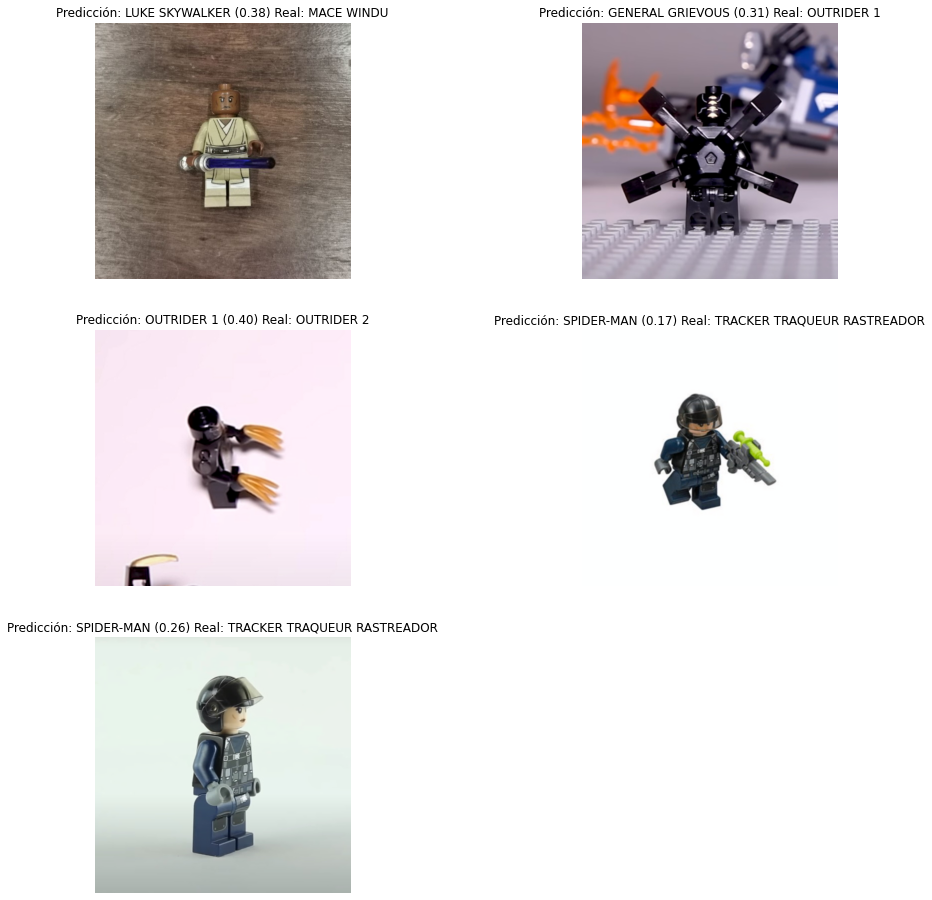

In [ ]:
# Mostramos las imágenes que nuestro modelo clasifico de forma incorrecta
plt.figure(figsize=(16, 16))
for ind, image in enumerate(error_images):
    plt.subplot(math.ceil(len(error_images) / int(len(error_images) ** 0.5)), int(len(error_images) ** 0.5), ind + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0).numpy()))
    plt.title(f'Predicción: {labels[error_pred[ind]]} ({error_prob[ind]:.2f}) Real: {labels[error_label[ind]]}')
    plt.axis('off')